# 03 - Full-Waveform Inversion (FWI)

This notebook is the third in a series of tutorial highlighting various aspects of seismic inversion based on Devito operators. In this second example we aim to highlight the core ideas behind seismic inversion, where we create an image of the subsurface from field recorded data. This tutorial follows on the modelling tutorial and will reuse the modelling and velocity model.

## Inversion requirement

Seismic inversion relies on two known parameters:

- **Field data** - or also called **recorded data**. This is a shot record corresponding to the true velocity model. In practice this data is acquired as described in the first tutorial. In order to simplify this tutorial we will fake field data by modelling it with the true velocity model.

- **Initial velocity model**. This is a velocity model that has been obtained by processing the field data. This model is a rough and very smooth estimate of the velocity as an initial estimate for the inversion. This is a necessary requirement for any optimization (method).

## Inversion computational setup

In this tutorial, we will introduce the gradient operator. This operator corresponds to the imaging condition introduced in the previous tutorial with some minor modifications that are defined by the objective function (also referred to in the tutorial series as the *functional*, *f*) and its gradient, *g*. We will define these two terms in the tutorial too.

## Notes on the operators

As we have already described the creation of a forward modelling operator, we will only call a wrapper function here. This wrapper already contains all the necessary operators for seismic modeling, imaging and inversion. Operators introduced for the first time in this tutorial will be properly described.

In [1]:
import numpy as np
%matplotlib inline

from devito import configuration
configuration['log-level'] = 'WARNING'

## Computational considerations

As we will see, FWI is computationally extremely demanding, even more than RTM. To keep this tutorial as lightwight as possible we therefore again use a very small demonstration model. We also define here a few parameters for the final example runs that can be changed to modify the overall runtime of the tutorial.

In [2]:
nshots = 9  # Number of shots to create gradient from
nreceivers = 101  # Number of receiver locations per shot 
fwi_iterations = 5  # Number of outer FWI iterations

# True and smooth velocity models

We will use a very simple model domain, consisting of a circle within a 2D domain. We will again use the "true" model to generate our synthetic shot data and use a "smooth" model as our initial guess. In this case the smooth model is very smooth indeed - it is simply a constant background velocity without any features.

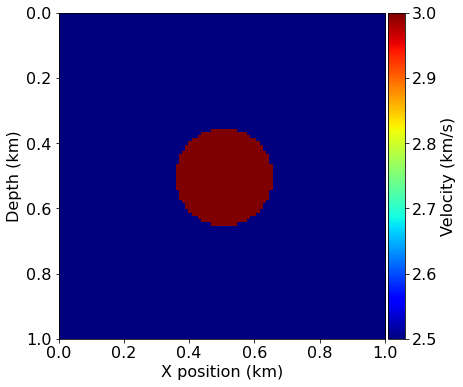

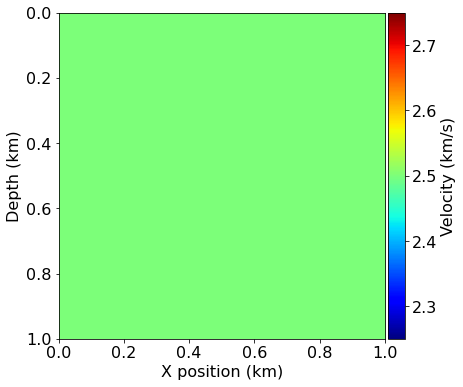

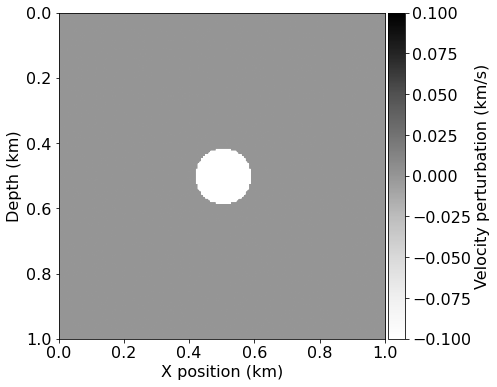

In [3]:
#NBVAL_IGNORE_OUTPUT
from seismic import demo_model, plot_velocity, plot_perturbation

# Define true and initial model
shape = (101, 101)  # Number of grid point (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40)

model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=40,
                    grid = model.grid)

plot_velocity(model)
plot_velocity(model0)
plot_perturbation(model0, model)

## Acquisition geometry

In this tutorial, we will use the easiest case for inversion, namely a transmission experiment. The sources are located on one side of the model and the receivers on the other side. This allows to record most of the information necessary for inversion, as reflections usually lead to poor inversion results.

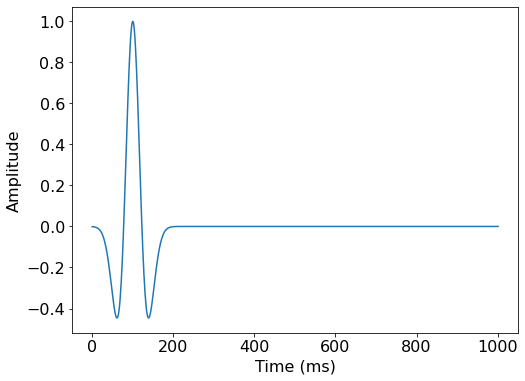

In [4]:
#NBVAL_IGNORE_OUTPUT
# Define acquisition geometry: source
from seismic import AcquisitionGeometry

t0 = 0.
tn = 1000. 
f0 = 0.010
# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, 0] = 20.  # Depth is 20m


# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

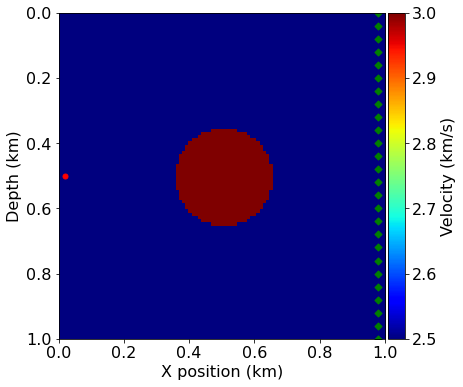

In [5]:
# Plot acquisition geometry
plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])

## True and smooth data

We can generate shot records for the true and smoothed initial velocity models, since the difference between them will again form the basis of our imaging procedure.

In [6]:
# Compute synthetic data with forward operator 
from seismic.acoustic import AcousticWaveSolver

solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d, _, _ = solver.forward(vp=model.vp)

In [7]:
# Compute initial data with forward operator 
smooth_d, _, _ = solver.forward(vp=model0.vp)

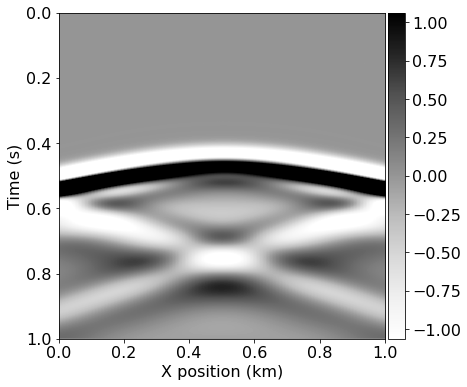

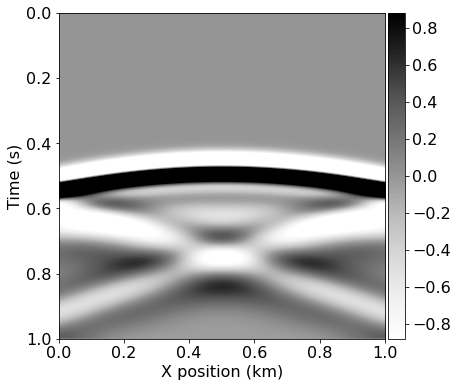

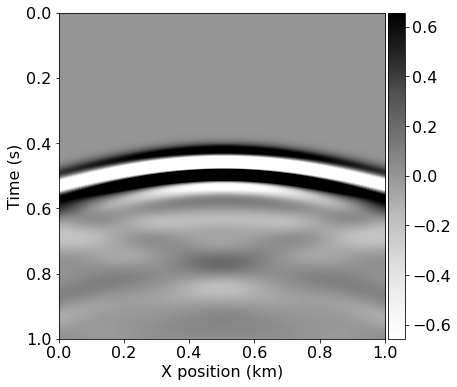

In [8]:
#NBVAL_IGNORE_OUTPUT
from seismic import plot_shotrecord

# Plot shot record for true and smooth velocity model and the difference
plot_shotrecord(true_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data, model, t0, tn)
plot_shotrecord(smooth_d.data - true_d.data, model, t0, tn)

# Full-Waveform Inversion


## Formulation

Full-waveform inversion (FWI) aims to invert an accurate model of the discrete wave velocity, $\mathbf{c}$, or equivalently the square slowness of the wave, $\mathbf{m} = \frac{1}{\mathbf{c}^2}$, from a given set of measurements of the pressure wavefield $\mathbf{u}$. This can be expressed as the following optimization problem [1, 2]:

\begin{aligned}
	\mathop{\hbox{minimize}}_{\mathbf{m}} \Phi_s(\mathbf{m})&=\frac{1}{2}\left\lVert\mathbf{P}_r
	\mathbf{u} - \mathbf{d}\right\rVert_2^2 \\
	\mathbf{u} &= \mathbf{A}(\mathbf{m})^{-1} \mathbf{P}_s^T \mathbf{q}_s, 
\end{aligned}

where $\mathbf{P}_r$ is the sampling operator at the receiver locations, $\mathbf{P}_s^T$ is the injection operator at the source locations, $\mathbf{A}(\mathbf{m})$ is the operator representing the discretized wave equation matrix, $\mathbf{u}$ is the discrete synthetic pressure wavefield, $\mathbf{q}_s$ is the corresponding pressure source and $\mathbf{d}$ is the measured data. It is worth noting that $\mathbf{m}$ is the unknown in this formulation and that multiple implementations of the wave equation operator $\mathbf{A}(\mathbf{m})$ are possible. 

We have already defined a concrete solver scheme for $\mathbf{A}(\mathbf{m})$ in the first tutorial, including appropriate implementations of the sampling operator $\mathbf{P}_r$ and source term $\mathbf{q}_s$.

To solve this optimization problem using a gradient-based method, we use the
adjoint-state method to evaluate the gradient $\nabla\Phi_s(\mathbf{m})$:

\begin{align}
 \nabla\Phi_s(\mathbf{m})=\sum_{\mathbf{t} =1}^{n_t}\mathbf{u}[\mathbf{t}] \mathbf{v}_{tt}[\mathbf{t}] =\mathbf{J}^T\delta\mathbf{d}_s,
\end{align}

where $n_t$ is the number of computational time steps, $\delta\mathbf{d}_s = \left(\mathbf{P}_r \mathbf{u} - \mathbf{d} \right)$ is the data residual (difference between the measured data and the modelled data), $\mathbf{J}$ is the Jacobian operator and $\mathbf{v}_{tt}$ is the second-order time derivative of the adjoint wavefield solving:

\begin{align}
 \mathbf{A}^T(\mathbf{m}) \mathbf{v} = \mathbf{P}_r^T \delta\mathbf{d}.
\end{align}

We see that the gradient of the FWI function is the previously defined imaging condition with an extra second-order time derivative. We will therefore reuse the operators defined previously inside a Devito wrapper.

## FWI gradient operator

To compute a single gradient $\nabla\Phi_s(\mathbf{m})$ in our optimization workflow we again use `solver.forward` to compute the entire forward wavefield $\mathbf{u}$ and a similar pre-defined gradient operator to compute the adjoint wavefield `v`. The gradient operator provided by our `solver` utility also computes the correlation between the wavefields, allowing us to encode a similar procedure to the previous imaging tutorial as our gradient calculation:

- Simulate the forward wavefield with the background velocity model to get the synthetic data and save the full wavefield $\mathbf{u}$
- Compute the data residual
- Back-propagate the data residual and compute on the fly the gradient contribution at each time step. 

This procedure is applied to multiple source positions and summed to obtain a gradient image of the subsurface. We again prepare the source locations for each shot and visualize them, before defining a single gradient computation over a number of shots as a single function.

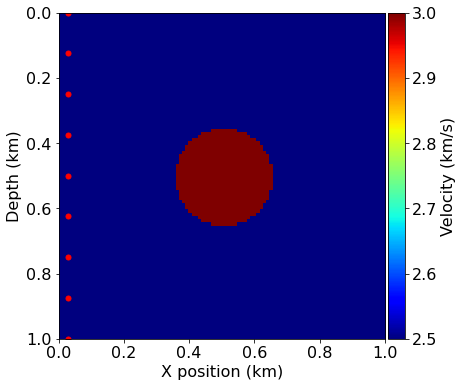

In [9]:
#NBVAL_IGNORE_OUTPUT

# Prepare the varying source locations sources
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

plot_velocity(model, source=source_locations)

In [10]:
# Create FWI gradient kernel 
from devito import Function, TimeFunction
from seismic import Receiver

import scipy
def fwi_gradient(vp_in):    
    # Create symbols to hold the gradient and residual
    grad = Function(name="grad", grid=model.grid)
    residual = Receiver(name='rec', grid=model.grid,
                        time_range=geometry.time_axis, 
                        coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]
        
        # Generate synthetic data from true model
        true_d, _, _ = solver.forward(vp=model.vp)
        
        # Compute smooth data and full forward wavefield u0
        smooth_d, u0, _ = solver.forward(vp=vp_in, save=True)
        
        # Compute gradient from data residual and update objective function 
        residual.data[:] = smooth_d.data[:] - true_d.data[:]
        
        objective += .5*np.linalg.norm(residual.data.flatten())**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    
    return objective, -grad.data

Having defined our FWI gradient procedure we can compute the initial iteration from our starting model. This allows us to visualize the gradient alongside the model perturbation and the effect of the gradient update on the model.

In [11]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.vp)
assert np.isclose(ff, 57283, rtol=1e0)

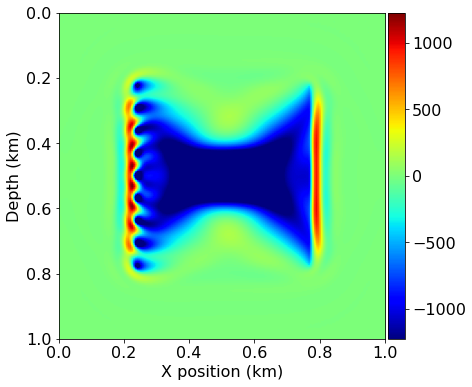

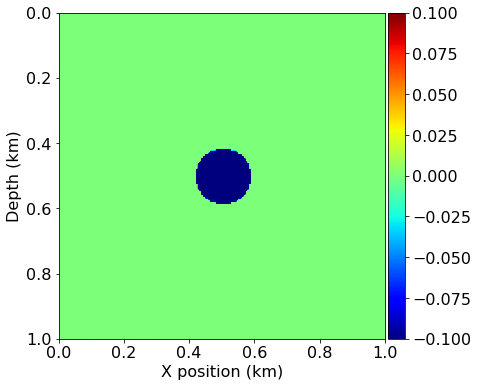

In [12]:
#NBVAL_IGNORE_OUTPUT
from seismic import plot_image

# Plot the FWI gradient
plot_image(update, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.vp.data - model.vp.data, cmap="jet")

We see that the gradient and the true perturbation have the same sign, therefore, with an appropriate scaling factor, we will update the model in the correct direction.

In [13]:
# Define bounding box constraints on the solution.
def apply_box_constraint(vp):
    # Maximum possible 'realistic' velocity is 3.5 km/sec
    # Minimum possible 'realistic' velocity is 2 km/sec
    return np.clip(vp, 2.0, 3.5)

In [14]:
#NBVAL_SKIP

# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.vp)
    
    # Store the history of the functional values
    history[i] = phi
    
    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .05 / np.abs(direction).max()
    
    # Update the model estimate and enforce minimum/maximum values
    model0.vp = apply_box_constraint(model0.vp.data - alpha * direction)
    
    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

Objective value is 57265.621845 at iteration 1
Objective value is 35755.516858 at iteration 2
Objective value is 20997.312671 at iteration 3
Objective value is 11545.767846 at iteration 4
Objective value is 5784.814165 at iteration 5


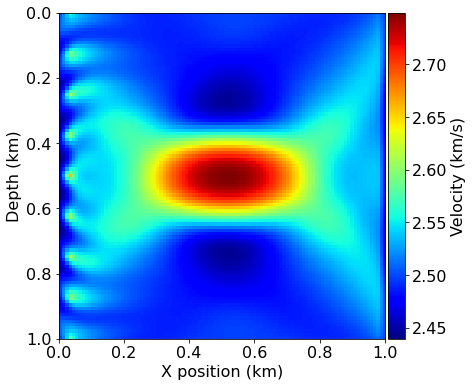

In [15]:
#NBVAL_IGNORE_OUTPUT

# Plot inverted velocity model
plot_velocity(model0)

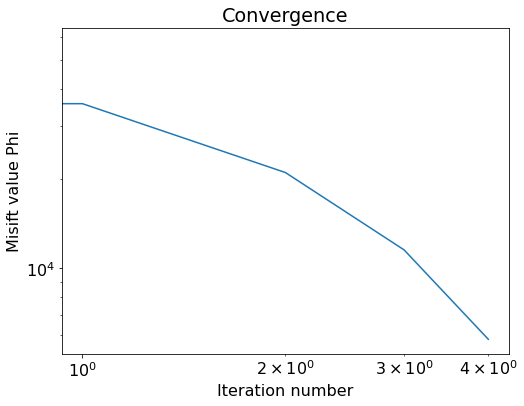

In [16]:
#NBVAL_SKIP
import matplotlib.pyplot as plt

# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()

## References

[1] _Virieux, J. and Operto, S.: An overview of full-waveform inversion in exploration geophysics, GEOPHYSICS, 74, WCC1–WCC26, doi:10.1190/1.3238367, http://library.seg.org/doi/abs/10.1190/1.3238367, 2009._

[2] _Haber, E., Chung, M., and Herrmann, F. J.: An effective method for parameter estimation with PDE constraints with multiple right hand sides, SIAM Journal on Optimization, 22, http://dx.doi.org/10.1137/11081126X, 2012._

<sup>This notebook is part of the tutorial "Optimised Symbolic Finite Difference Computation with Devito" presented at the Intel® HPC Developer Conference 2017.</sup>